In [305]:
from scipy.signal import firwin, lfilter, freqz, hilbert
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
import IPython
from scipy.io import loadmat, wavfile

# bandpass FIR filter.
def bandpass_firwin(ntaps, lowcut, highcut, Fs, window='hamming'):    
    taps = firwin(ntaps, [lowcut, highcut], fs=Fs, pass_zero=False, window=window, scale=True)
    return taps

# bandpass FIR filter.
def lowpass_firwin(ntaps, fcut, Fs, window='hamming'):    
    taps = firwin(ntaps, fcut, fs=Fs, window=window, scale=True)
    return taps

# função para calcular a potência de um sinal
def potSinal(x):
    return (x**2).mean()

def filterNoDelay(h, x):
    """
    h: impulse response (symmetric)
    x: input signal 
    y: output signal
    """   
    N = h.size
    x = np.pad(x, (0, int(N/2)),'constant')
    y = lfilter(h,1,x)
    
    return y[int(N/2):y.size]

In [306]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Caso 1: AM-DSB-SC

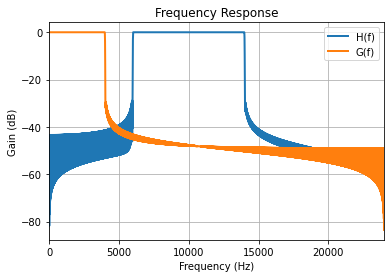

In [355]:
# Exemplo 1 (AM-DSB-SC):

Fs     = 48e3     # frequência de amostragem do sinal de áudio
fc_tx  = 10e3     # frequência da portadora
B_sig  = 4e3      # largura de banda do sinal de áudio
ntaps  = 4096+1   # número de coeficientes dos filtros
SNR    = 10       # SNR desejada em dB
π      = np.pi

# frequências de corte do filtro passa-faixa:
lowcut  = fc_tx-B_sig
highcut = fc_tx+B_sig

h = bandpass_firwin(ntaps, lowcut, highcut, Fs)
g = lowpass_firwin(ntaps, B_sig, Fs)

w, H = freqz(h, fs=Fs, worN=4096)
w, G = freqz(g, fs=Fs, worN=4096)

# plota o valor absoluto das respostas em frequência dos filtros
plt.plot(w, 10*np.log10(np.abs(H)), linewidth=2, label = 'H(f)')
plt.plot(w, 10*np.log10(np.abs(G)), linewidth=2, label = 'G(f)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.title('Frequency Response')
plt.legend()
plt.grid(True)
plt.xlim(min(w),max(w));

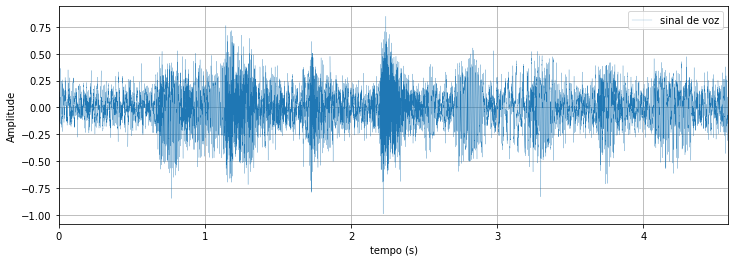

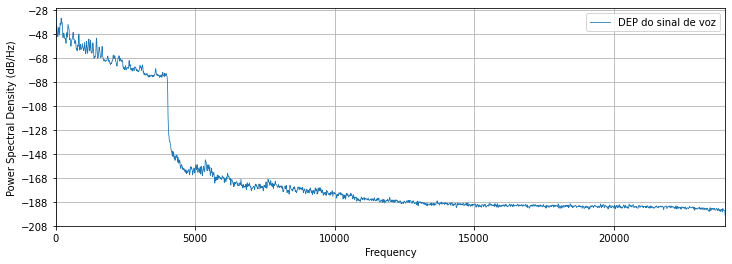

In [356]:
y = loadmat('voz.mat')['y']

# Pre-processamento:
x = y[int(20e3):,0]
x = x/abs(x).max(0)

x = filterNoDelay(g, x)

t = np.arange(0, len(x))*1/Fs
plt.figure(figsize =(12,4))
plt.plot(t, x, linewidth = 0.2, label='sinal de voz')
plt.xlabel('tempo (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(min(t),max(t));
plt.legend()

plt.figure(figsize =(12,4))
plt.psd(x, Fs=Fs, label='DEP do sinal de voz', linewidth=0.8, NFFT=4096); # estima DEP do sinal
plt.legend();
plt.xlim(0,Fs/2);
plt.grid(True);

In [326]:
wavfile.write('voz.wav', int(Fs), x.astype(np.float32))

In [327]:
IPython.display.Audio('voz.wav')

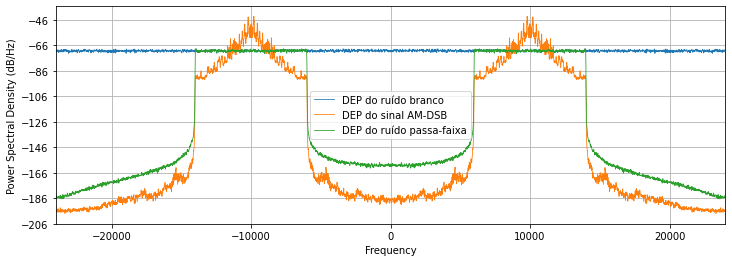

In [357]:
# Modula sinal de voz DSB-SC e plota espectro do sinal modulado:
s_dsb = x*np.cos(2*π*fc_tx*t)

Ps = potSinal(s_dsb) # calcula potência do sinal modulado
Pn = Ps/10**(SNR/10) # calcula potência do ruído na banda do sinal
N0 = Pn/(4*B_sig)    # calcula N0

σ2 = N0*Fs # variância 
μ  = 0         # média

# Adiciona ruído branco
ruido    = normal(μ, np.sqrt(σ2), len(s_dsb))
ruido_pf = filterNoDelay(h, ruido)

plt.figure(figsize =(12,4))
plt.psd(ruido, Fs=Fs, label='DEP do ruído branco',sides='twosided', linewidth=0.8, NFFT=4096); # estima DEP do sinal
plt.psd(s_dsb, Fs=Fs, label='DEP do sinal AM-DSB',sides='twosided', linewidth=0.8, NFFT=4096); # estima DEP do sinal
plt.psd(ruido_pf, Fs=Fs, label='DEP do ruído passa-faixa',sides='twosided', linewidth=0.8, NFFT=4096); # estima DEP do sinal
plt.legend();
plt.xlim(-Fs/2,Fs/2);
plt.grid(True)

**Calculando a $\mathrm{SNR}$ pré-demodulador**

In [358]:
SNRpre = 10*np.log10(potSinal(s_dsb)/potSinal(ruido_pf))
print('SNRpre = %.2f dB'%SNRpre)

SNRpre = 9.99 dB


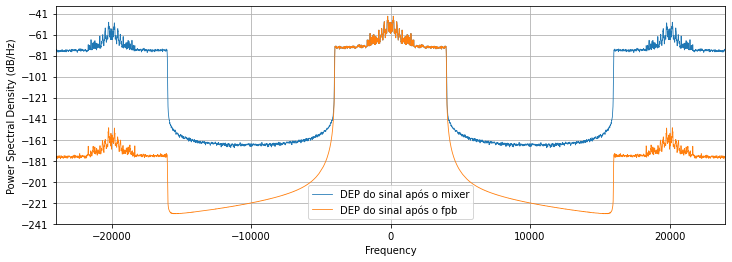

In [362]:
s_dsb_rx = s_dsb + ruido
s_dsb_rx = filterNoDelay(h, s_dsb_rx)

s_demod  = s_dsb_rx*np.cos(2*π*fc_tx*t)
x_demod  = filterNoDelay(g, s_demod)

plt.figure(figsize =(12,4))
plt.psd(s_demod, Fs=Fs, label='DEP do sinal após o mixer',sides='twosided', linewidth=0.8, NFFT=4096); # estima DEP do sinal
plt.psd(x_demod, Fs=Fs, label='DEP do sinal após o fpb',sides='twosided', linewidth=0.8, NFFT=4096); # estima DEP do sinal
plt.legend();
plt.xlim(-Fs/2,Fs/2);
plt.grid(True)

**Calculando a $\mathrm{SNR}$ pós-demodulador**

In [331]:
ruido_pb  = ruido_pf*np.cos(2*π*fc_tx*t)
ruido_pb  = filterNoDelay(g, ruido_pb) 

s_pb  = s_dsb*np.cos(2*π*fc_tx*t)
s_pb  = filterNoDelay(g, s_pb) 

SNRpos = 10*np.log10(potSinal(s_pb)/potSinal(ruido_pb))
print('SNRpos = %.2f dB'%SNRpos)

SNRpos = 13.01 dB


In [363]:
x_demod = x_demod/abs(x_demod).max(0)
wavfile.write('voz_demodAMDSBSC.wav', int(Fs), x_demod.astype(np.float32))

In [364]:
IPython.display.Audio('voz_demodAMDSBSC.wav')

### Caso 2: AM-SSB

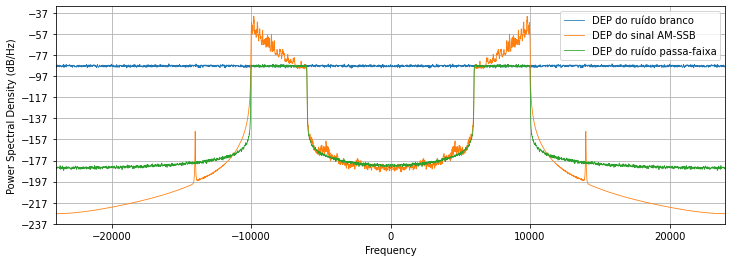

In [348]:
SNR = 30

# frequências de corte do filtro passa-faixa:
lowcut  = fc_tx-B_sig
highcut = fc_tx

h = bandpass_firwin(ntaps, lowcut, highcut, Fs)

# Modula sinal de voz SSB e plota epectro do sinal modulado:
s_ssb = 1/np.sqrt(2)*( x*np.cos(2*π*fc_tx*t) + np.imag(hilbert(x))*np.sin(2*π*fc_tx*t) )

Ps = potSinal(s_ssb)
Pn = Ps/10**(SNR/10)
N0 = Pn/(2*B_sig)

σ2 = N0*Fs # variância 
μ  = 0         # média

# Adiciona ruído branco
ruido    = normal(μ, np.sqrt(σ2), len(s_ssb))
ruido_pf = filterNoDelay(h, ruido)

plt.figure(figsize =(12,4))
plt.psd(ruido, Fs=Fs, label='DEP do ruído branco',sides='twosided', linewidth=0.8, NFFT=4096); # estima DEP do sinal
plt.psd(s_ssb, Fs=Fs, label='DEP do sinal AM-SSB',sides='twosided', linewidth=0.8, NFFT=4096); # estima DEP do sinal
plt.psd(ruido_pf, Fs=Fs, label='DEP do ruído passa-faixa',sides='twosided', linewidth=0.8, NFFT=4096); # estima DEP do sinal
plt.legend();
plt.xlim(-Fs/2,Fs/2);
plt.grid(True)

**Calculando a $\mathrm{SNR}$ pré-demodulador**

In [349]:
SNRpre = 10*np.log10(potSinal(s_ssb)/potSinal(ruido_pf))
print('SNRpre = %.2f dB'%SNRpre)

SNRpre = 30.06 dB


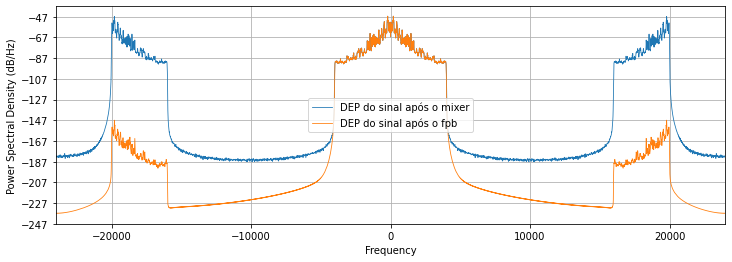

In [350]:
s_ssb_rx = s_ssb + ruido
s_ssb_rx = filterNoDelay(h, s_ssb_rx)

s_demod  = s_ssb_rx*np.cos(2*π*fc_tx*t)
x_demod  = filterNoDelay(g, s_demod)

plt.figure(figsize =(12,4))
plt.psd(s_demod, Fs=Fs, label='DEP do sinal após o mixer',sides='twosided', linewidth=0.8, NFFT=4096); # estima DEP do sinal
plt.psd(x_demod, Fs=Fs, label='DEP do sinal após o fpb',sides='twosided', linewidth=0.8, NFFT=4096); # estima DEP do sinal
plt.legend();
plt.xlim(-Fs/2,Fs/2);
plt.grid(True)

**Calculando a $\mathrm{SNR}$ pós-demodulador**

In [351]:
ruido_pb  = ruido_pf*np.cos(2*π*fc_tx*t)
ruido_pb  = filterNoDelay(g, ruido_pb) 

s_pb  = s_ssb*np.cos(2*π*fc_tx*t)
s_pb  = filterNoDelay(g, s_pb) 

SNRpos = 10*np.log10(potSinal(s_pb)/potSinal(ruido_pb))
print('SNRpos = %.2f dB'%SNRpos)

SNRpos = 30.07 dB


In [352]:
x_demod = x_demod/abs(x_demod).max(0)
wavfile.write('voz_demodAMSSB.wav', int(Fs), x_demod.astype(np.float32))

In [353]:
IPython.display.Audio('voz_demodAMSSB.wav')

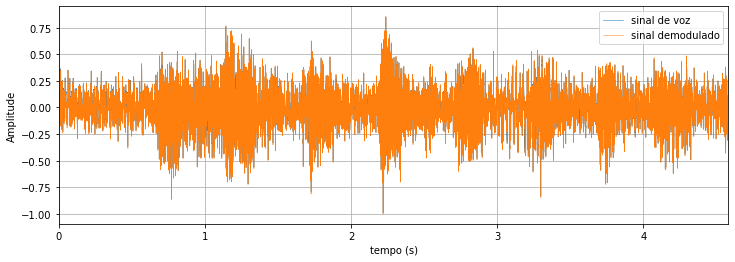

In [354]:
t = np.arange(0, len(x))*1/Fs
plt.figure(figsize =(12,4))
plt.plot(t, x, linewidth = 0.5, label='sinal de voz')
plt.plot(t, x_demod, linewidth = 0.5, label='sinal demodulado')
plt.xlabel('tempo (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(min(t), max(t));
plt.legend();